In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

import wf_psf

import wf_psf.SimPSFToolkit as SimPSFToolkit
import wf_psf.utils as wf_utils
import wf_psf.tf_psf_field as tf_psf_field

# Plot style & colormap

import matplotlib as mpl
import matplotlib.ticker as mtick
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import ImageGrid

from IPython.display import display, HTML

from tabulate import tabulate

# Pre-defined colormap
top = mpl.cm.get_cmap('Oranges_r', 128)
bottom = mpl.cm.get_cmap('Blues', 128)
newcolors = np.vstack((top(np.linspace(0, 1, 128)),
                       bottom(np.linspace(0, 1, 128))))
newcmp = ListedColormap(newcolors, name='OrangeBlue')


plot_style = {
    'mpl_toolkits.legacy_colorbar': False,
    'axes.formatter.use_mathtext': True,
    'text.usetex': False,
}
mpl.rcParams.update(plot_style)

plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)    # fontsize of the tick labels

# Model Parameters

In [2]:
# Parameters
d_max = 2
max_order = 45
x_lims = [0, 1e3]
y_lims = [0, 1e3]
grid_points = [4, 4]
n_bins = 20
auto_init = True
verbose = True

oversampling_rate = 3.
output_Q = 3.

max_wfe_rms = 0.1
output_dim = 32
LP_filter_length = 2
euclid_obsc = True

pupil_diameter = 256

# Super resolved PSFs
super_out_Q = 1
super_out_res = 64

max_bins = 350

In [3]:
# Generate Zernike maps
zernikes = wf_psf.utils.zernike_generator(n_zernikes=max_order, wfe_dim=pupil_diameter)

# Initialize PSF simulator
sim_PSF_toolkit = wf_psf.SimPSFToolkit(
    zernikes, max_order=max_order, max_wfe_rms=max_wfe_rms, oversampling_rate=oversampling_rate,
    output_Q=super_out_Q, output_dim=super_out_res, pupil_diameter=pupil_diameter, euclid_obsc=euclid_obsc,
    LP_filter_length=LP_filter_length)

# Initialize PSF field
gen_poly_fieldPSF = wf_psf.GenPolyFieldPSF(sim_PSF_toolkit, d_max=d_max,
                                    grid_points=grid_points, max_order=max_order,
                                    x_lims=x_lims, y_lims=y_lims, n_bins=max_bins,
                                    lim_max_wfe_rms=max_wfe_rms, verbose=verbose)

In [125]:
# Load SEDs

# SED folder path
SED_path = './../../../wf-psf/data/SEDs/save_SEDs/'
# Output saving path
output_folder = './../outputs/output-SEDs/'
plots_folder = './../outputs/plots/'

stellar_SEDs = np.load(SED_path + 'SEDs.npy', allow_pickle=True)
stellar_lambdas = np.load(SED_path + 'lambdas.npy', allow_pickle=True)
SED_name = ['O5V', 'B0V', 'B5-7V', 'A0V', 'A5V', 'F0V', 'F5V', 'G0V', 'G5V', 'K0V', 'K5V', 'M0V', 'M5V']
n_SEDs = len(SED_name)
# Create packed SEDs and lambdas lists
SED_list = []
for it in range(n_SEDs):
    concat_SED_wv = np.concatenate((stellar_lambdas.reshape(-1,1),
                                    stellar_SEDs[it,:].reshape(-1,1)), axis=1)
    SED_list.append(concat_SED_wv)

In [5]:
# Choose the location (randomly)
pos_np = np.random.rand(1, 2)

pos_np[:,0] = pos_np[:,0]*(x_lims[1] - x_lims[0]) + x_lims[0]
pos_np[:,1] = pos_np[:,1]*(y_lims[1] - y_lims[0]) + y_lims[0]

# Generate Ground Truth PSFs

In [6]:
# Generate all the polychromatic PSFs
gt_poly_psf_list = []
zernike_coef_list = []

# Generate polychromatic PSF at 3x Euclid resolution
for it in range(n_SEDs):
    _psf, _zernike, _ = gen_poly_fieldPSF.get_poly_PSF(xv_flat=pos_np[0, 0],
                                                        yv_flat=pos_np[0, 1],
                                                        SED=SED_list[it])
    gt_poly_psf_list.append(_psf)
    zernike_coef_list.append(_zernike)  

In [7]:
# Generate numpy arrays from the lists
gt_poly_psf_np = np.array(gt_poly_psf_list)
zernike_coef_np = np.array(zernike_coef_list)
SED_np = np.array(SED_list)

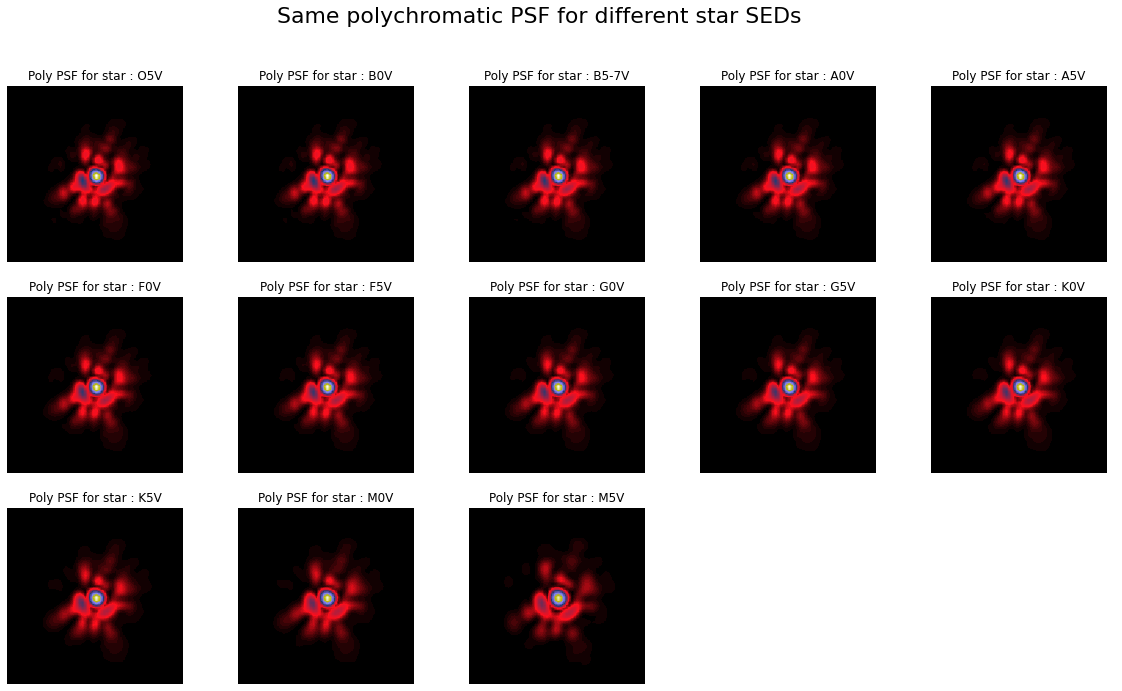

In [8]:
vmax = np.max(np.abs(gt_poly_psf_np))

fig, ax = plt.subplots(3, 5, figsize=(20,11), facecolor='white')
fig.suptitle('Same polychromatic PSF for different star SEDs', fontsize=22)

for axis,psf_,star_name in zip(ax.ravel(),gt_poly_psf_list,SED_name):
    im = axis.imshow(psf_,cmap='gist_stern', vmax=vmax, vmin=0)
    axis.set_title('Poly PSF for star : '+ star_name)
    axis.set_xticks([])


for axis in ax.ravel():
    axis.axis('off')

#plt.savefig('../outputs/plots/PSF_for_each_SED.pdf')
plt.show()

In [9]:
# for psf_, star_name in zip(gt_poly_psf_list,SED_name):
#     fig = plt.figure(figsize=(5,5), facecolor='white')
#     plt.imshow(psf_,cmap='gist_stern', vmax=vmax, vmin=0)
#     plt.title('Poly PSF for star : '+ star_name)
#     plt.savefig(plots_folder+'poly_psf_'+star_name+'.jpg')
#     plt.close(fig)

# button_str = '<input type="radio" name="images" onclick="show{}();">{}</input>\n'
# image_str = '<div id="image{}">\n  <img src="./../outputs/plots/poly_psf_{}.jpg"\n  width="300"\n  height="300" >\n</div>\n'
# display_str = '  document.getElementById(\'image{}\').style.display =\'{}\';\n'

# html = 'Select an Image:\n'
# for it,star_name in enumerate(SED_name):
#     html = html + button_str.format(str(it+1), star_name)
# for it,star_name in enumerate(SED_name):
#     html = html + image_str.format(str(it+1), star_name)
# html = html + '<script>\n'

# for it,star_name in enumerate(SED_name):
#     html = html + 'function show{}(){{\n'.format(str(it+1))
#     for it_, star_name_ in enumerate(SED_name):
#         if it_ == it:
#             status = 'block'
#         else:
#             status = 'none'
#         html = html + display_str.format(it_+1, status)
#     html = html + '}\n'

# html = html + 'show1()\n</script>'

# display(HTML(html))

In [11]:

example_html = """
    Select an Image:
    <input type="radio" name="images" onclick="show1();" checked>A0V</input>
    <input type="radio" name="images" onclick="show2();">A5V</input>
    <input type="radio" name="images" onclick="show3();">B0V</input>

    <div id="image1">
      <img src="./../outputs/plots/poly_psf_A0V.jpg">
    </div>
    <div id="image2">
      <img src="./../outputs/plots/poly_psf_A5V.jpg">
    </div>
    <div id="image3">
      <img src="./../outputs/plots/poly_psf_B0V.jpg">
    </div>
  
    <script>
    function show1(){
      document.getElementById('image1').style.display ='block';
      document.getElementById('image2').style.display ='none';
      document.getElementById('image3').style.display ='none';
    }
    function show2(){
      document.getElementById('image2').style.display ='block';
      document.getElementById('image1').style.display ='none';
      document.getElementById('image3').style.display ='none';
    }
    function show3(){
      document.getElementById('image3').style.display ='block';
      document.getElementById('image1').style.display ='none';
      document.getElementById('image2').style.display ='none';
    }
    show1()
    </script>
"""

# Generate low SED resolution PSFs

In [10]:
n_bins_list = [4,8,16,32,64]

# Generate all the polychromatic PSFs
poly_psf_list = []

for n_bins in n_bins_list:

    # Set right number of bins
    gen_poly_fieldPSF.n_bins = n_bins

    psf_list = []
    # Generate polychromatic PSF at 3x Euclid resolution
    for it in range(n_SEDs):
        _psf, _, _ = gen_poly_fieldPSF.get_poly_PSF(xv_flat=pos_np[0, 0],
                                                            yv_flat=pos_np[0, 1],
                                                            SED=SED_list[it])
        psf_list.append(_psf)
    
    print('13 psfs done with N = ', n_bins)

    poly_psf_list.append(psf_list)

13 psfs done with N =  4
13 psfs done with N =  8
13 psfs done with N =  16
13 psfs done with N =  32
13 psfs done with N =  64


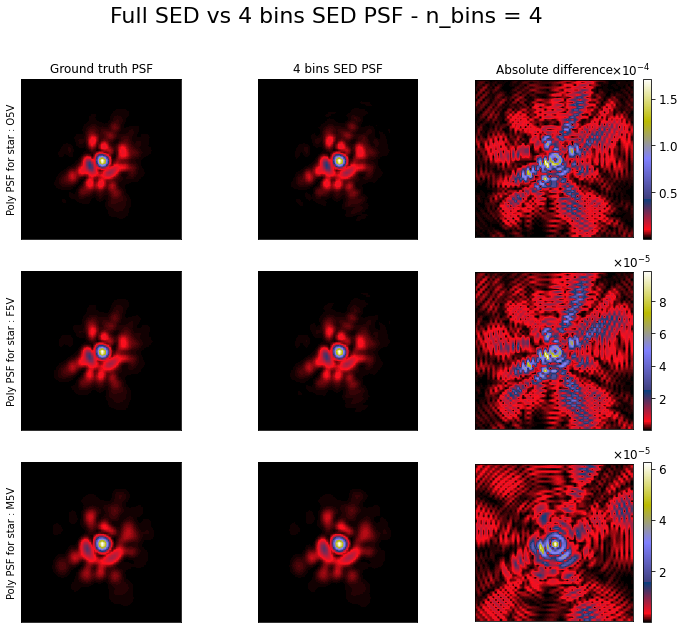

In [47]:
display_stars = [0, 6, 12]

fig, ax = plt.subplots(3, 3, figsize=(12,10), facecolor='white')
fig.suptitle('Full SED vs 4 bins SED PSF - n_bins = 4', fontsize=22)

for itr, star_id in enumerate(display_stars):
    im = ax[itr][0].imshow(gt_poly_psf_list[star_id],cmap='gist_stern')
    ax[itr][0].set_ylabel('Poly PSF for star : '+ SED_name[star_id])
    if itr == 0:
        ax[itr][0].set_title('Ground truth PSF')
    ax[itr][0].set_xticks([])
    ax[itr][0].set_yticks([])

    im = ax[itr][1].imshow(poly_psf_list[0][star_id],cmap='gist_stern')
    if itr == 0:
        ax[itr][1].set_title('4 bins SED PSF')
    ax[itr][1].set_xticks([])
    ax[itr][1].set_yticks([])

    im = ax[itr][2].imshow(np.abs(gt_poly_psf_list[star_id]-poly_psf_list[0][star_id]),cmap='gist_stern')
    if itr == 0:
        ax[itr][2].set_title('Absolute difference')
    ax[itr][2].set_xticks([])
    ax[itr][2].set_yticks([])
    cbar = plt.colorbar(im, ax=ax[itr][2])
    cbar.formatter.set_powerlimits((0, 0))

#plt.savefig('../outputs/plots/PSF_for_each_SED.pdf')
plt.show()

In [64]:
def get_RMSE(psf1, psf2):
    residual = np.sqrt(np.mean((psf1 - psf2)**2, axis=(0,1)))
    gt_mean  = np.sqrt(np.mean(psf1**2, axis=(0,1)))
    return residual, 100. * (residual/gt_mean)

In [66]:
abs_rmse_mat = np.zeros((len(n_bins_list), len(SED_name)))
rel_rmse_mat = np.zeros((len(n_bins_list), len(SED_name)))

for n_bins in range(len(n_bins_list)):
    for star_id in range(len(SED_name)):
        abs_rmse_mat[n_bins, star_id], rel_rmse_mat[n_bins, star_id] = get_RMSE(gt_poly_psf_list[star_id], poly_psf_list[n_bins][star_id])

In [131]:
table = (np.around(rel_rmse_mat, decimals=2)).tolist()

table.insert(0,SED_name.copy())
table[0].insert(0,'n_bins')
for idx, n_bins in enumerate(n_bins_list):
    table[idx+1].insert(0, n_bins)
print('\t\t\t\tRelative PSF error [%]')
print(tabulate(table))


				Relative PSF error [%]
------  ----  ----  -----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----
n_bins  O5V   B0V   B5-7V  A0V   A5V   F0V   F5V   G0V   G5V   K0V   K5V   M0V   M5V
4       1.75  1.72  1.52   1.46  1.37  1.19  1.11  1.01  0.97  0.91  0.73  0.64  0.51
8       0.45  0.45  0.39   0.37  0.34  0.28  0.26  0.23  0.23  0.21  0.17  0.15  0.13
16      0.14  0.14  0.12   0.12  0.12  0.1   0.09  0.09  0.09  0.07  0.07  0.06  0.04
32      0.06  0.06  0.07   0.06  0.05  0.05  0.05  0.04  0.04  0.04  0.03  0.05  0.05
64      0.02  0.02  0.03   0.02  0.02  0.02  0.02  0.02  0.02  0.02  0.01  0.01  0.02
------  ----  ----  -----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----
